Runfile for the simple heat pump
================================
mainly for testing (2024-04-10, BA)

The working fluid is an alkane mixture, the high temperature storage is water and the low temperature storage is methanol.


In [1]:
import carbatpy as cb

_RESULTS_ = cb._RESULTS_DIR

C:\Users\atakan\sciebo\Python\carbatpy\carbatpy\src\helpers\file_copy.py


Fluid mixtures are set:

In [2]:
FLUID = "Propane * Butane * Pentane * Hexane"
comp = [.75, 0.05, 0.15, 0.05]
comp = [0.4,	0.3,	0.3, 0.0]  # [0.164,.3330,.50300,0.0]

FLS = "Water"  #
FLCOLD = "Methanol"  # "Water"  #

flm = cb.fprop.FluidModel(FLUID)
myFluid = cb.fprop.Fluid(flm, comp)

secFlm = cb.fprop.FluidModel(FLS)
secFluid = cb.fprop.Fluid(secFlm, [1.])

coldFlm = cb.fprop.FluidModel(FLCOLD)
coldFluid = cb.fprop.Fluid(coldFlm, [1.])

Now temperatures, pressures and machine efficiencies must be fixed:

In [6]:
# Condenser(c) and storage (s), secondary fluids fix all, temperatures(T in K),
# pressures (p in Pa)
_ETA_S_ = 0.67  # interesting when changed from 0.69 to 0.65, the efficiency
# decreases, the reason is the low quality along throtteling then
_STORAGE_T_IN_ = cb._T_SURROUNDING
_COLD_STORAGE_T_IN_ = _STORAGE_T_IN_
_STORAGE_T_OUT_ = 363.  # 395.0
_COLD_STORAGE_T_OUT_ = 260.15
_STORAGE_P_IN_ = 5e5
_COLD_STORAGE_P_IN_ = 5e5
_Q_DOT_MIN_ = 1e3  # and heat_flow rate (W)
_D_T_SUPER_ = 5  # super heating of working fluid
_D_T_MIN_ = 4.  # minimum approach temperature (pinch point)
# high T-storages
state_sec_out = secFluid.set_state([_STORAGE_T_OUT_, _STORAGE_P_IN_], "TP")
state_sec_in = secFluid.set_state([_STORAGE_T_IN_, _STORAGE_P_IN_], "TP")

#  low T storages:
state_cold_out = coldFluid.set_state(
    [_COLD_STORAGE_T_OUT_, _COLD_STORAGE_P_IN_], "TP")
state_cold_in = coldFluid.set_state(
    [_COLD_STORAGE_T_IN_, _COLD_STORAGE_P_IN_], "TP")

For the working fluid it is set, that it should be super heated at the compressor inlet (out_cond). 
Also it is selected that the pressure in the condenser is the pressure at which the working fluid 
is saturated (x=1) at the high temperature of the (high-temperature) storage.
The pressure in the evaporator is selected such that the working fluid is saturated (x=1) at the 
temperature of the environment minus the superheating:

In [7]:




# working fluid
T_DEW = _STORAGE_T_OUT_  # + _D_T_MIN_
state_in_cond = myFluid.set_state([T_DEW, 1.], "TQ")  # find high pressure
state_out_cond = myFluid.set_state([_STORAGE_T_IN_ + _D_T_MIN_,
                                    state_in_cond[1]], "TP")
state_satv_evap = myFluid.set_state(
    [_STORAGE_T_IN_-_D_T_MIN_-_D_T_SUPER_, 1.], "TQ")  # find minimum pressure
p_low = state_satv_evap[1]

T_IN = _STORAGE_T_IN_ - _D_T_MIN_

state_out_evap = myFluid.set_state([p_low,
                                    T_IN], "PT")

FIXED_POINTS = {"eta_s": _ETA_S_,
                "p_low": state_out_evap[1],
                "p_high": state_in_cond[1],
                "T_hh": _STORAGE_T_OUT_,
                "h_h_out_sec": state_sec_out[2],
                "h_h_out_w": state_out_cond[2],
                "h_l_out_cold": state_cold_out[2],
                "h_l_out_w": state_out_evap[2],
                "T_hl": _STORAGE_T_IN_,
                "T_lh": _STORAGE_T_IN_,
                "T_ll": _COLD_STORAGE_T_OUT_,  # 256.0,
                "Q_dot_h": _Q_DOT_MIN_,
                "d_temp_min": _D_T_MIN_}

print(
    f"p-ratio: {state_in_cond[1]/state_out_evap[1]: .2f}, p_low: {state_out_evap[1]/1e5: .2} bar")
    

p-ratio:  13.13, p_low:  0.83 bar


Now a new instance of HeatPump is created:

In [8]:
hp0 = cb.hp_simple.HeatPump([myFluid, secFluid, coldFluid], FIXED_POINTS)
print(hp0.evaluation)

{'Q_dot_h': 1000.0, 'Power': 0.0, 'T_hh': 363.0, 'T_ll': 260.15, 'exergy_loss_rate': 0}


The heat pump is now evaluated and the plotted. Because it is verbose, several state properties are  printed:

Start:

Propane * Butane * Pentane * Hexane, composition: [0.4, 0.3, 0.3, 0.0]
T:284.15 K, p: 0.83 bar,  h:  495.86 kJ/kg, s: 2.201 kJ/kg K

After compressor

Propane * Butane * Pentane * Hexane, composition: [0.4, 0.3, 0.3, 0.0]
T:386.88 K, p: 10.86 bar,  h:  661.91 kJ/kg, s: 2.347 kJ/kg K

------pinch-plot running -----plot:True
after heat exchanger: condenser

Propane * Butane * Pentane * Hexane, composition: [0.4, 0.3, 0.3, 0.0]
T:292.15 K, p: 10.86 bar,  h:  139.82 kJ/kg, s: 0.827 kJ/kg K

power:318.0537516502713 W, heat-Evap. 681.9462483497286 W

after throttle:

Propane * Butane * Pentane * Hexane, composition: [0.4, 0.3, 0.3, 0.0]
T:252.15 K, p: 0.83 bar,  h:  139.82 kJ/kg, s: 0.867 kJ/kg K

Quality: 0.231
None

Propane * Butane * Pentane * Hexane, composition: [0.4, 0.3, 0.3, 0.0]
T:252.15 K, p: 0.83 bar,  h:  139.82 kJ/kg, s: 0.867 kJ/kg K

Quality: 0.231
------pinch-plot running -----plot:True
after heat exchanger: evaporator

Propane * Butane * Pentane * Hexane, composition

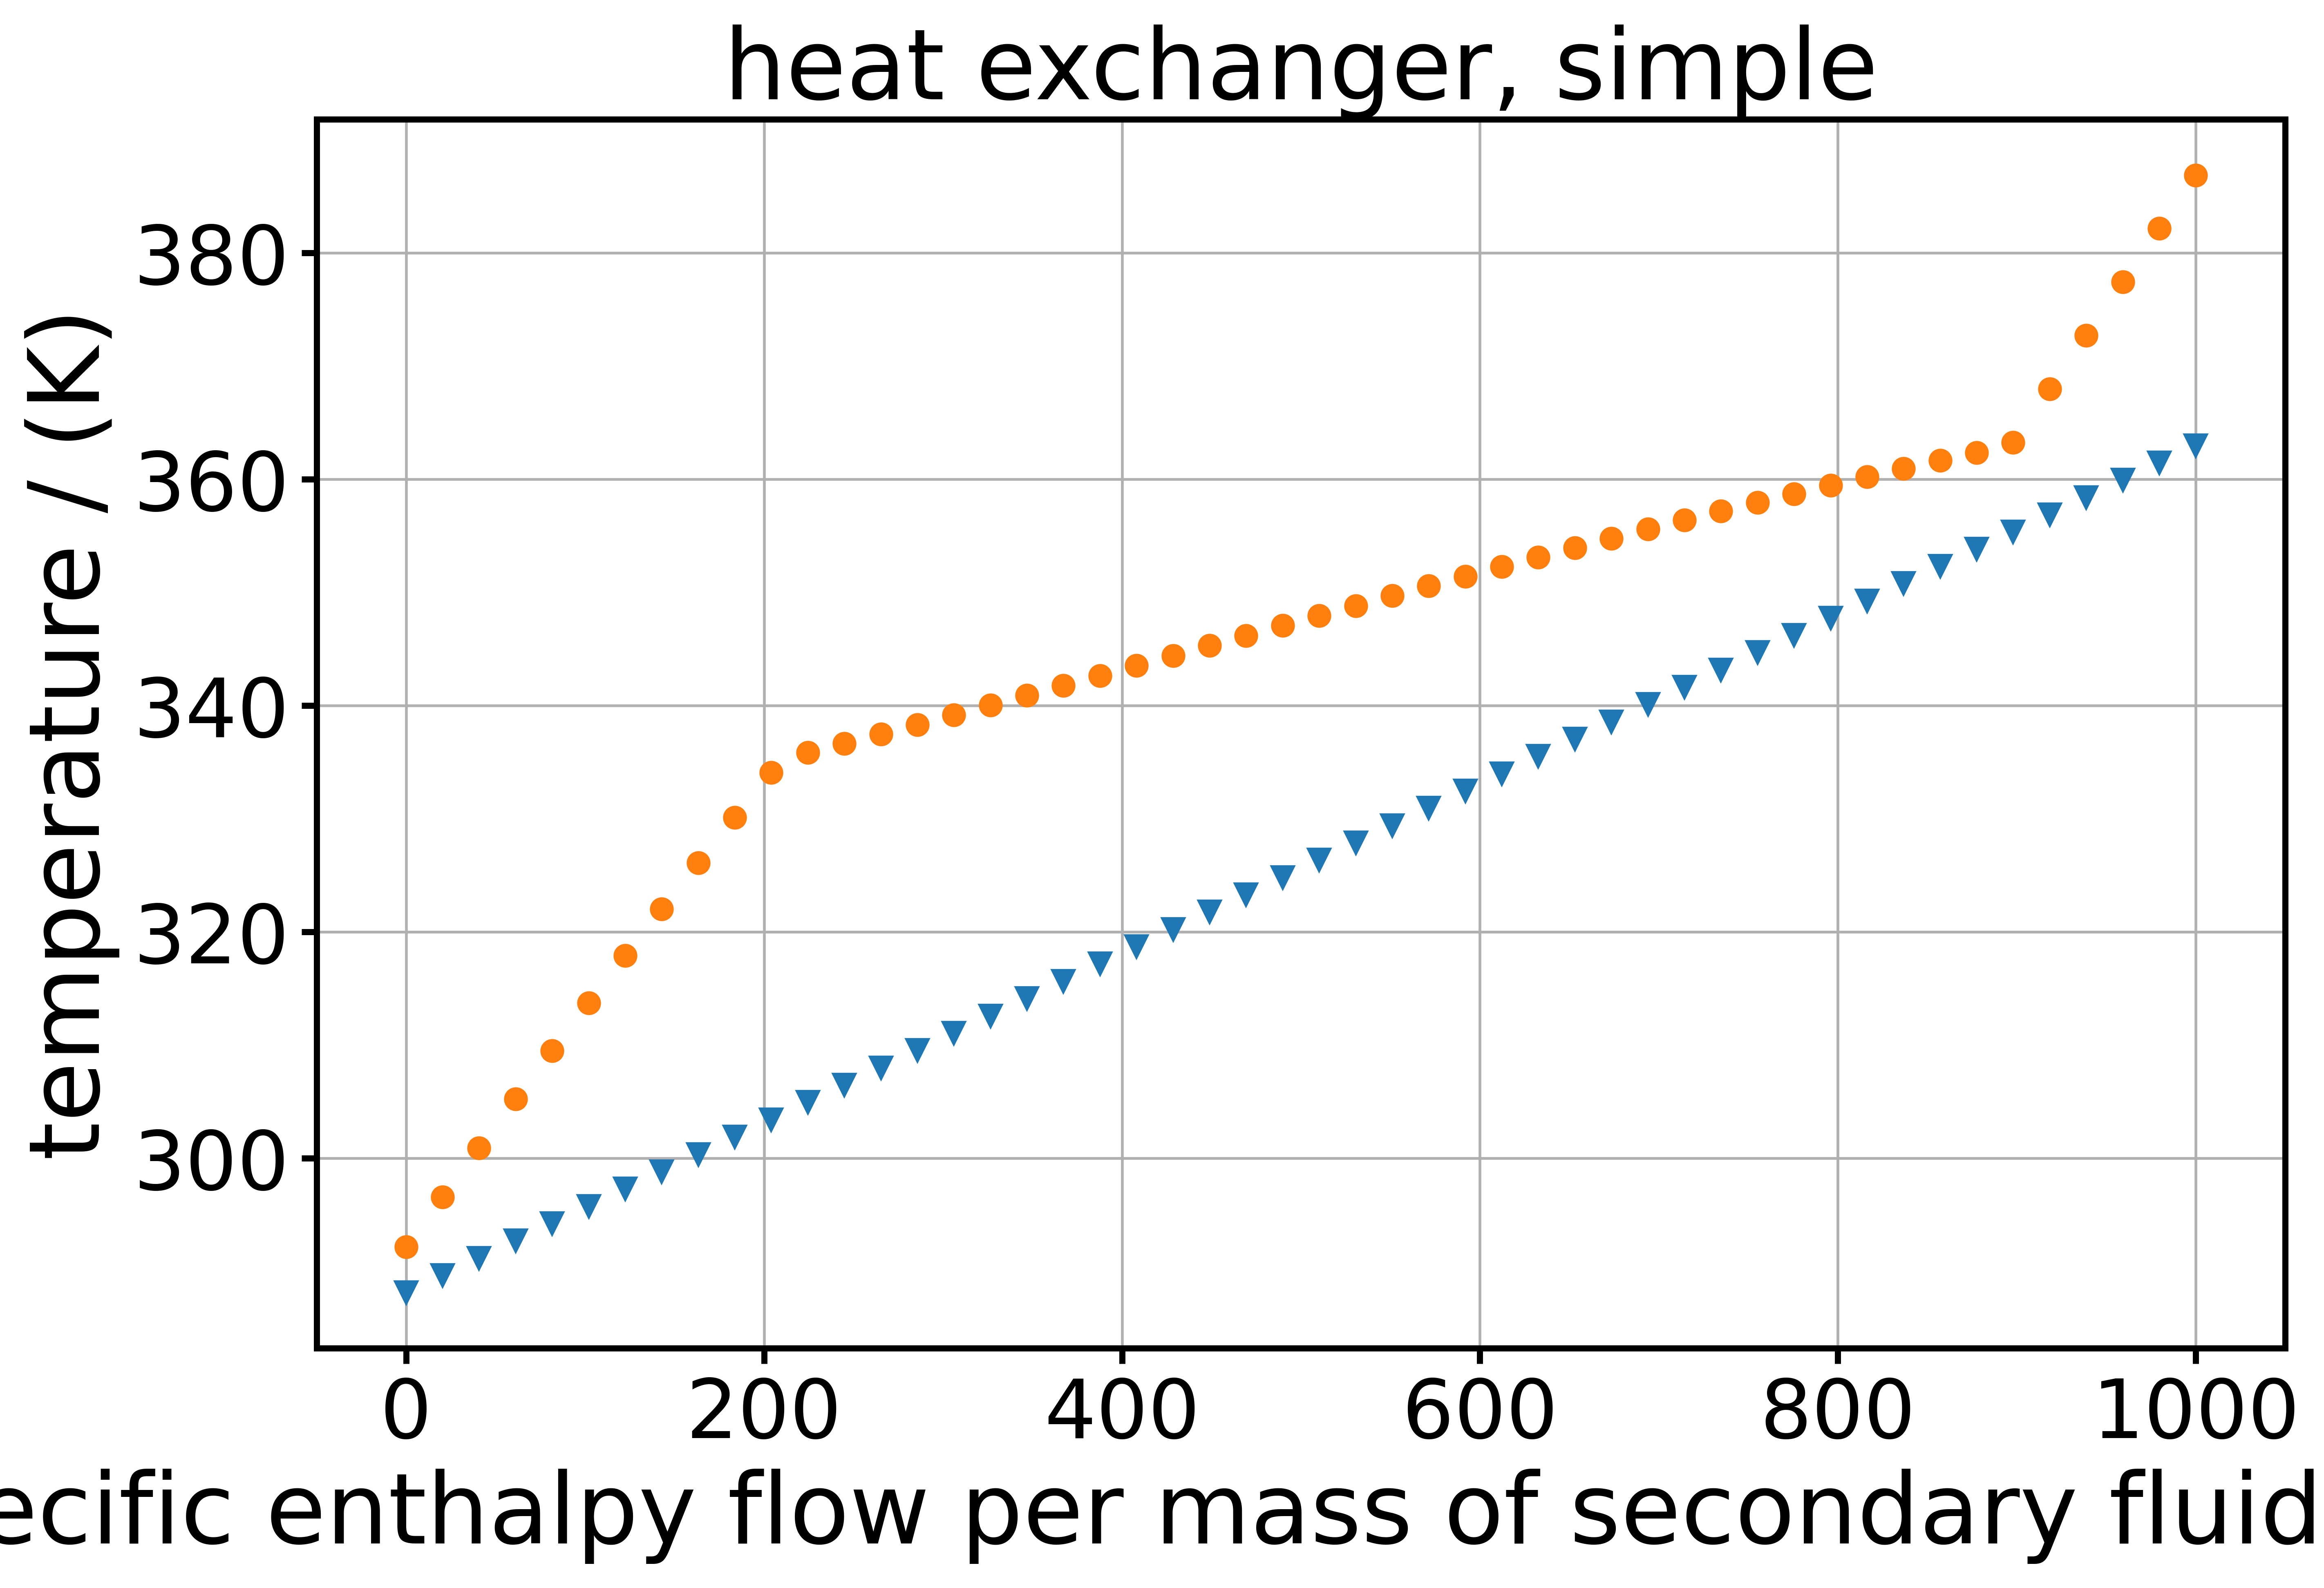

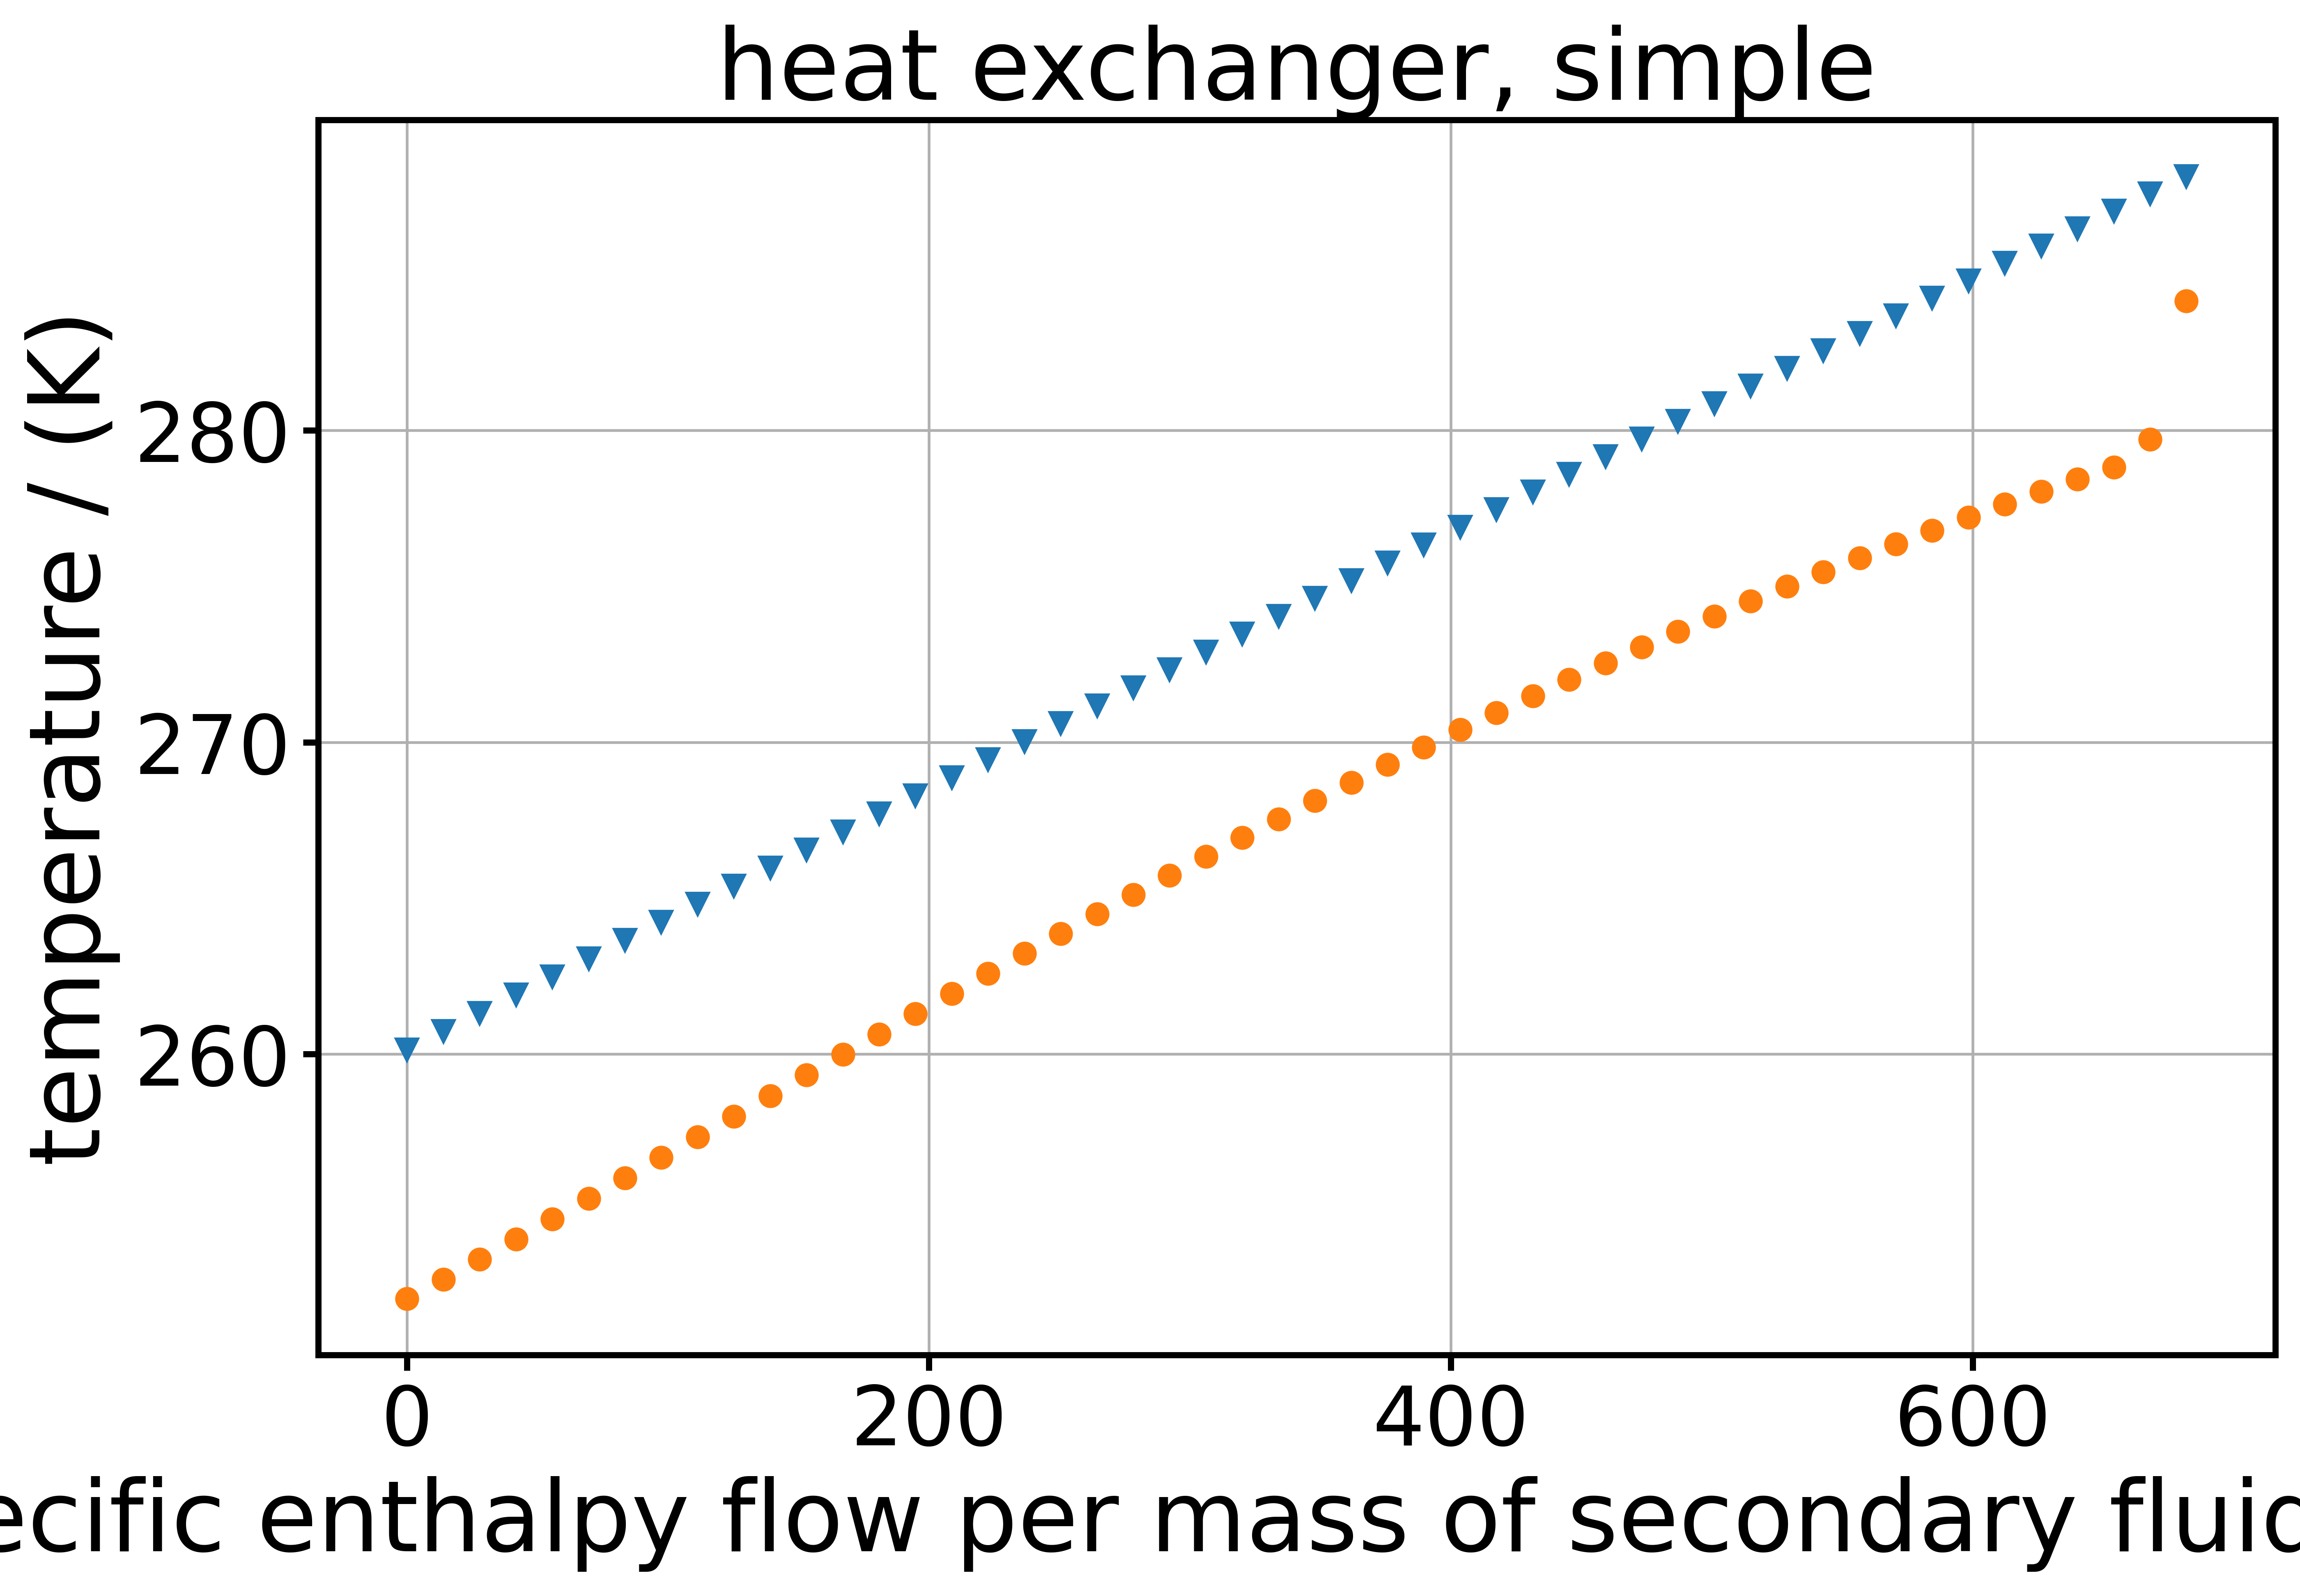

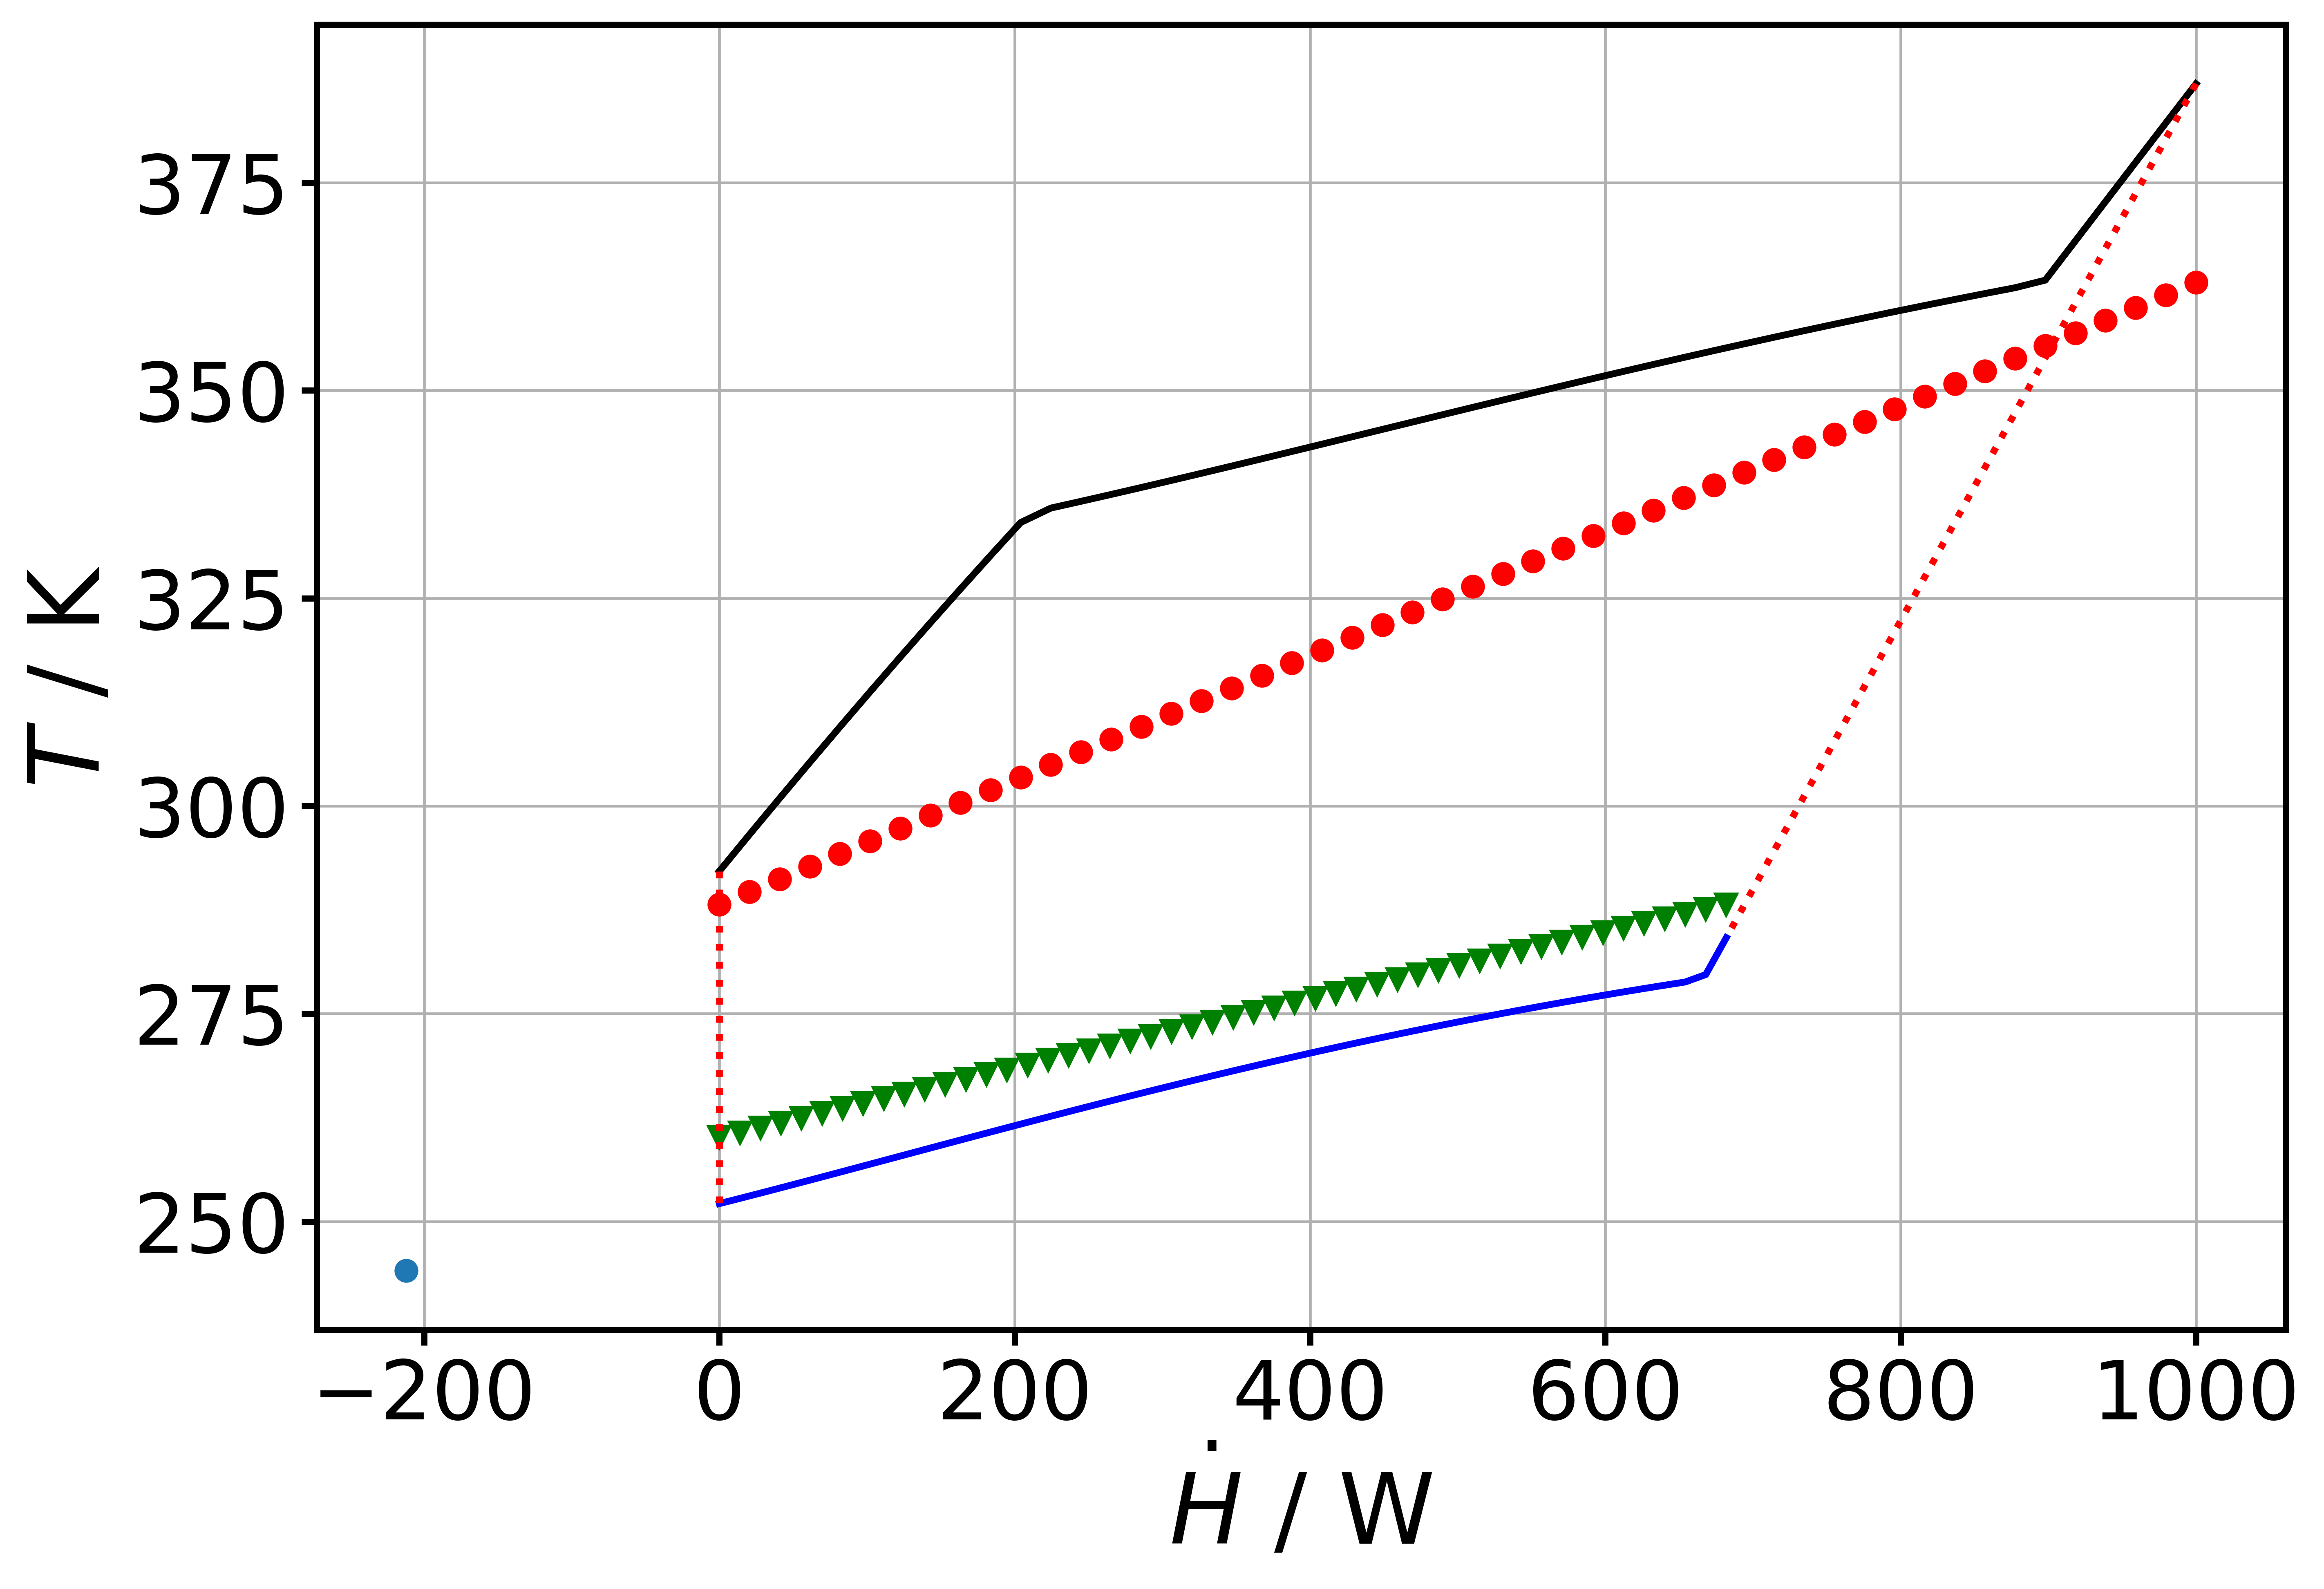

In [9]:

cop = hp0.calc_p_high(FIXED_POINTS["p_high"], verbose=True)
print(hp0.evaluation)
hp0.hp_plot()
print(hp0.evaluation, "----------------n")
out = hp0.evaluation
print(
    f"COP: {cop},p-ratio: {out['p_high']/out['p_low']:.2f}, p_low {out['p_low']/1e5:.2f} bar")

print(
    f'exergy loss rate: {out["exergy_loss_rate"]}, eff: {1-out["exergy_loss_rate"]/out["Power"]:.4f}')
